In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from string import punctuation
from emot.emo_unicode import UNICODE_EMO, EMOTICONS # for converting emojis/emoticons into word
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from itertools import islice # for sorting a dictionary
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

stop_words = set(stopwords.words('english'))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

# Reading the data from source and having overview of the same.

In [2]:
newsTopicData = pd.read_excel('/Users/pritigirishvankudre/DayX_Lockdown Practice/News Topic Classification/Data_Train.xlsx')
newsTopicData.head(15)

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3
5,BEIJING: Chinese tech giant Huawei has announc...,1
6,Mumbai: India Inc's external commercial borrow...,3
7,"On Wednesday, Federal Reserve Chairman Jerome ...",3
8,What more can you give to the audience? I have...,2
9,"com, Arbaaz Khan spoke about getting back to D...",2


In [3]:
newsTopicData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7628 entries, 0 to 7627
Data columns (total 2 columns):
STORY      7628 non-null object
SECTION    7628 non-null int64
dtypes: int64(1), object(1)
memory usage: 119.3+ KB


We understand that the source data do not contain any null values.

# Following some basic data pre processing steps along with some data scrubbing

In [4]:
'''Scrubbing the data for some unwanted data and to convert emoji/emoticons to meaningful words'''

def scrub_data(text):
    """Basic cleaning of texts."""
    
    # converting to lower case
    text = str(text).lower()
    
    # remove urls
    text = re.sub("https?://\S+|www\.\S+", '', text)
    
    # remove html markup
    text = re.sub("(<.*?>)","",text)
    
    # elaborate emoji
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    
    # elaborate emoticons
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    
    # remove non-ascii and digits
    text = re.sub("(\\W|\\d)"," ",text)
    
    # remove whitespace
    text = text.strip()
    
    # remove punctuations
    text = ' '.join([word for word in text.split() if word not in punctuation])
    
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [5]:
newsTopicData['STORY'] = newsTopicData['STORY'].apply(lambda x: scrub_data(x))
newsTopicData.head(15)

,STORY,SECTION
0,painful huge reversal fee income unheard among...,3
1,formidable opposition alliance among congress ...,0
2,asian currencies trading lower today south kor...,3
3,want answer question click answer clicking ans...,1
4,global markets gold prices edged today disappo...,3
5,beijing chinese tech giant huawei announced pl...,1
6,mumbai india inc external commercial borrowing...,3
7,wednesday federal reserve chairman jerome powe...,3
8,give audience already done yeh hai aashiqui py...,2
9,com arbaaz khan spoke getting back dabangg sal...,2


# Tokenize: Splitting sentence into words and then converting words to base form using Lemmatization technique

In [6]:
'''Tokeninzing sentence to word'''

newsTopicData['STORY_Token'] = newsTopicData['STORY'].apply(lambda x: nltk.word_tokenize(x))
newsTopicData.head(15)

,STORY,SECTION,STORY_Token
0,painful huge reversal fee income unheard among...,3,"[painful, huge, reversal, fee, income, unheard..."
1,formidable opposition alliance among congress ...,0,"[formidable, opposition, alliance, among, cong..."
2,asian currencies trading lower today south kor...,3,"[asian, currencies, trading, lower, today, sou..."
3,want answer question click answer clicking ans...,1,"[want, answer, question, click, answer, clicki..."
4,global markets gold prices edged today disappo...,3,"[global, markets, gold, prices, edged, today, ..."
5,beijing chinese tech giant huawei announced pl...,1,"[beijing, chinese, tech, giant, huawei, announ..."
6,mumbai india inc external commercial borrowing...,3,"[mumbai, india, inc, external, commercial, bor..."
7,wednesday federal reserve chairman jerome powe...,3,"[wednesday, federal, reserve, chairman, jerome..."
8,give audience already done yeh hai aashiqui py...,2,"[give, audience, already, done, yeh, hai, aash..."
9,com arbaaz khan spoke getting back dabangg sal...,2,"[com, arbaaz, khan, spoke, getting, back, daba..."


In [7]:
'''Lemmatization: Converting to stem word and joining back into sentence'''

lemmatizer = WordNetLemmatizer()

newsTopicData['STORY_TokenLemma'] = newsTopicData['STORY_Token'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) 
                                                                                           for word in x]))
newsTopicData.head(15)

,STORY,SECTION,STORY_Token,STORY_TokenLemma
0,painful huge reversal fee income unheard among...,3,"[painful, huge, reversal, fee, income, unheard...",painful huge reversal fee income unheard among...
1,formidable opposition alliance among congress ...,0,"[formidable, opposition, alliance, among, cong...",formidable opposition alliance among congress ...
2,asian currencies trading lower today south kor...,3,"[asian, currencies, trading, lower, today, sou...",asian currency trading lower today south korea...
3,want answer question click answer clicking ans...,1,"[want, answer, question, click, answer, clicki...",want answer question click answer clicking ans...
4,global markets gold prices edged today disappo...,3,"[global, markets, gold, prices, edged, today, ...",global market gold price edged today disappoin...
5,beijing chinese tech giant huawei announced pl...,1,"[beijing, chinese, tech, giant, huawei, announ...",beijing chinese tech giant huawei announced pl...
6,mumbai india inc external commercial borrowing...,3,"[mumbai, india, inc, external, commercial, bor...",mumbai india inc external commercial borrowing...
7,wednesday federal reserve chairman jerome powe...,3,"[wednesday, federal, reserve, chairman, jerome...",wednesday federal reserve chairman jerome powe...
8,give audience already done yeh hai aashiqui py...,2,"[give, audience, already, done, yeh, hai, aash...",give audience already done yeh hai aashiqui py...
9,com arbaaz khan spoke getting back dabangg sal...,2,"[com, arbaaz, khan, spoke, getting, back, daba...",com arbaaz khan spoke getting back dabangg sal...


In [8]:
'''Understanding parts of speech'''

def get_NounList(text):
    tb=TextBlob(text)
    nounlist=[]
    for word,pos in tb.tags:
        if pos == 'NN':
            nounlist.append(word)
    nounlist=" ".join(word for word in set(nounlist))
    return nounlist

def get_AdjList(text):
    tb=TextBlob(text)
    adjlist=[]
    for word,pos in tb.tags:
        if pos == 'JJ':
            adjlist.append(word)
    adjlist=" ".join(word for word in set(adjlist))
    return adjlist

def get_AdvList(text):
    tb=TextBlob(text)
    advlist=[]
    for word,pos in tb.tags:
        if pos == 'RB':
            advlist.append(word)
    advlist=" ".join(word for word in set(advlist))
    return advlist

In [9]:
newsTopicData['STORY_TokenLemma_Noun'] = newsTopicData['STORY_TokenLemma'].apply(lambda x: get_NounList(x))
newsTopicData['STORY_TokenLemma_Adj'] = newsTopicData['STORY_TokenLemma'].apply(lambda x: get_AdjList(x))
newsTopicData['STORY_TokenLemma_Adv'] = newsTopicData['STORY_TokenLemma'].apply(lambda x: get_AdvList(x))

newsTopicData.drop(['STORY','STORY_Token'], axis =1, inplace=True)

newsTopicData.head(15)

,SECTION,STORY_TokenLemma,STORY_TokenLemma_Noun,STORY_TokenLemma_Adj,STORY_TokenLemma_Adv
0,3,painful huge reversal fee income unheard among...,gain investor fee bank loan book future sacrif...,come huge fee nasty unheard stable structured ...,essentially rather well
1,0,formidable opposition alliance among congress ...,vikas prajatantrikConfusion alliance jmmConfus...,congress formidable,
2,3,asian currency trading lower today south korea...,index china rupiah currency ringgit dollar str...,indonesian korean major previous south asian j...,offshore however close
3,1,want answer question click answer clicking ans...,question proceed answer homepage prefix voice ...,many neighbour icon follow user ask,already reply also
4,3,global market gold price edged today disappoin...,concern appetite activity ounce spot equity pr...,chinese european global asian,
5,1,beijing chinese tech giant huawei announced pl...,industry smartphone effort component security ...,thursday chinese huawei ltd next western u,directly instead
6,3,mumbai india inc external commercial borrowing...,mumbai period borrowing bank rbiConfusion firm...,inc commercial domestic total external automat...,ago
7,3,wednesday federal reserve chairman jerome powe...,move bond rate interest direction risk jerome ...,close muted federal economic opposite gilt wed...,
8,2,give audience already done yeh hai aashiqui py...,audience kind pyaar tune situation hai aashiqu...,bad good give,already always
9,2,com arbaaz khan spoke getting back dabangg sal...,brother salman com set arbaaz character song y...,saw dabangg,already back perfectly


# EDA : Exploratory Data Analysis, we will try to plot most commonly used words sectionwise using normal chat as well as word cloud to understand insights if we get any

In [10]:
newsTopicData_EDA = newsTopicData.copy()
newsTopicData_EDA.head()

,SECTION,STORY_TokenLemma,STORY_TokenLemma_Noun,STORY_TokenLemma_Adj,STORY_TokenLemma_Adv
0,3,painful huge reversal fee income unheard among...,gain investor fee bank loan book future sacrif...,come huge fee nasty unheard stable structured ...,essentially rather well
1,0,formidable opposition alliance among congress ...,vikas prajatantrikConfusion alliance jmmConfus...,congress formidable,
2,3,asian currency trading lower today south korea...,index china rupiah currency ringgit dollar str...,indonesian korean major previous south asian j...,offshore however close
3,1,want answer question click answer clicking ans...,question proceed answer homepage prefix voice ...,many neighbour icon follow user ask,already reply also
4,3,global market gold price edged today disappoin...,concern appetite activity ounce spot equity pr...,chinese european global asian,


In [11]:
def frequency_count(text):
    
    for word in nltk.word_tokenize(text):
        if word not in stop_words:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1

In [12]:
def weighted_frequency_count():
    
    maximum_frequncy = max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)

In [13]:
def sorting_slicing_word_frequencies():
    
    sortedWord_frequencies = dict(sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True))
    sortedWord_frequencies_Top10 = dict(islice(sortedWord_frequencies.items(), 10))

    keys = sortedWord_frequencies_Top10.keys()
    values = sortedWord_frequencies_Top10.values()
    
    return (keys, values)

In [14]:
word_frequencies = {}
newsTopicData_EDA[newsTopicData_EDA['SECTION'] == 0]['STORY_TokenLemma'].apply(lambda x: frequency_count(x))
weighted_frequency_count()
keys_1, values_1 = sorting_slicing_word_frequencies()

word_frequencies = {}
newsTopicData_EDA[newsTopicData_EDA['SECTION'] == 0]['STORY_TokenLemma_Noun'].apply(lambda x: frequency_count(x))
weighted_frequency_count()
keys_2, values_2 = sorting_slicing_word_frequencies()

word_frequencies = {}
newsTopicData_EDA[newsTopicData_EDA['SECTION'] == 1]['STORY_TokenLemma'].apply(lambda x: frequency_count(x))
weighted_frequency_count()
keys_3, values_3 = sorting_slicing_word_frequencies()

word_frequencies = {}
newsTopicData_EDA[newsTopicData_EDA['SECTION'] == 1]['STORY_TokenLemma_Noun'].apply(lambda x: frequency_count(x))
weighted_frequency_count()
keys_4, values_4 = sorting_slicing_word_frequencies()

word_frequencies = {}
newsTopicData_EDA[newsTopicData_EDA['SECTION'] == 2]['STORY_TokenLemma'].apply(lambda x: frequency_count(x))
weighted_frequency_count()
keys_5, values_5 = sorting_slicing_word_frequencies()

word_frequencies = {}
newsTopicData_EDA[newsTopicData_EDA['SECTION'] == 2]['STORY_TokenLemma_Noun'].apply(lambda x: frequency_count(x))
weighted_frequency_count()
keys_6, values_6 = sorting_slicing_word_frequencies()

word_frequencies = {}
newsTopicData_EDA[newsTopicData_EDA['SECTION'] == 3]['STORY_TokenLemma'].apply(lambda x: frequency_count(x))
weighted_frequency_count()
keys_7, values_7 = sorting_slicing_word_frequencies()

word_frequencies = {}
newsTopicData_EDA[newsTopicData_EDA['SECTION'] == 3]['STORY_TokenLemma_Noun'].apply(lambda x: frequency_count(x))
weighted_frequency_count()
keys_8, values_8 = sorting_slicing_word_frequencies()

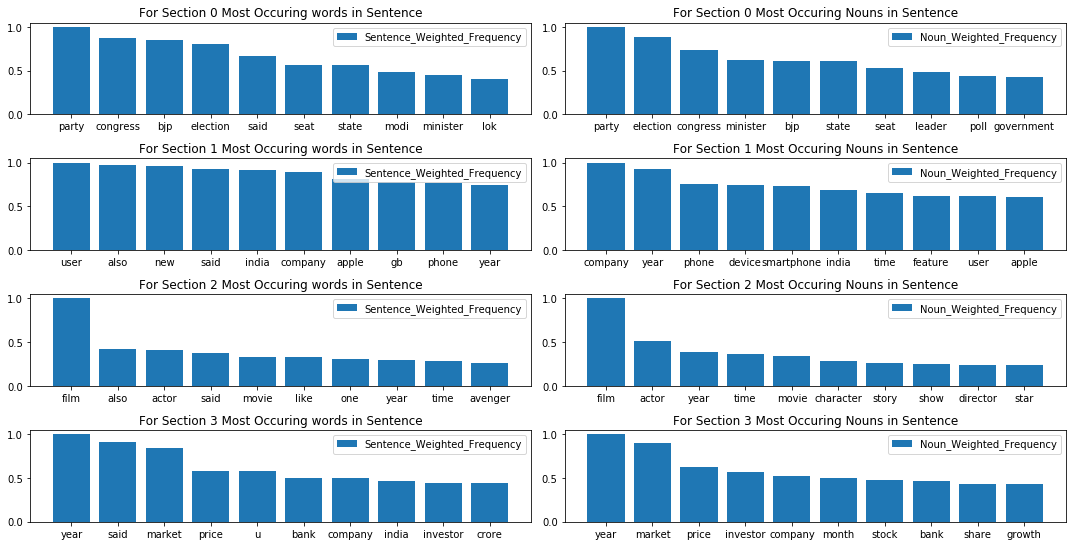

In [15]:
plt.figure(figsize=(15,15))
plt.subplot(821)
plt.title('For Section 0 Most Occuring words in Sentence')
plt.bar(keys_1, values_1, label='Sentence_Weighted_Frequency')
plt.legend(loc='best')
plt.subplot(822)
plt.title('For Section 0 Most Occuring Nouns in Sentence')
plt.bar(keys_2, values_2, label='Noun_Weighted_Frequency')
plt.legend(loc='best')
plt.subplot(823)
plt.title('For Section 1 Most Occuring words in Sentence')
plt.bar(keys_3, values_3, label='Sentence_Weighted_Frequency')
plt.legend(loc='best')
plt.subplot(824)
plt.title('For Section 1 Most Occuring Nouns in Sentence')
plt.bar(keys_4, values_4, label='Noun_Weighted_Frequency')
plt.legend(loc='best')
plt.subplot(825)
plt.title('For Section 2 Most Occuring words in Sentence')
plt.bar(keys_5, values_5, label='Sentence_Weighted_Frequency')
plt.legend(loc='best')
plt.subplot(826)
plt.title('For Section 2 Most Occuring Nouns in Sentence')
plt.bar(keys_6, values_6, label='Noun_Weighted_Frequency')
plt.legend(loc='best')
plt.subplot(827)
plt.title('For Section 3 Most Occuring words in Sentence')
plt.bar(keys_7, values_7, label='Sentence_Weighted_Frequency')
plt.legend(loc='best')
plt.subplot(828)
plt.title('For Section 3 Most Occuring Nouns in Sentence')
plt.bar(keys_8, values_8, label='Noun_Weighted_Frequency')
plt.legend(loc='best')
plt.tight_layout()

Understanding from Most Occuring Words and Nouns in Each section

- We can make an assumption that Section 0 topic mentions about Politics
- We can make an assumption that Section 1 topic mentions about Smartphones/Electronic gadgets
- We can make an assumption that Section 2 topic mentions about Films/Entertainment
- We can make an assumption that Section 3 topic mentions about Business/Finance

# We will try to understand the distribution of words through WordCloud

In [16]:
# Function for generating word clouds
def generate_wordcloud(data,title):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(str(data))
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(' '.join("Section {} Sentence".format(title)),fontsize=16)
    plt.show()

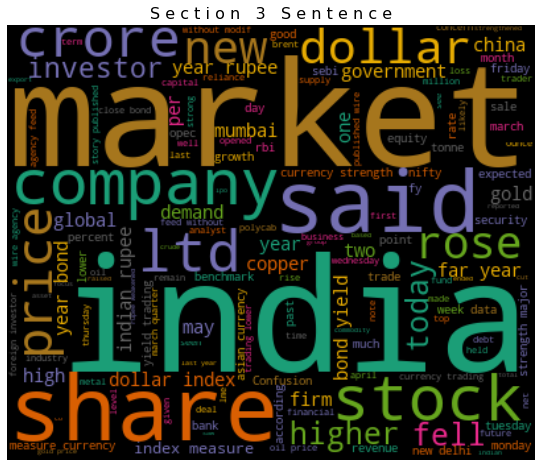

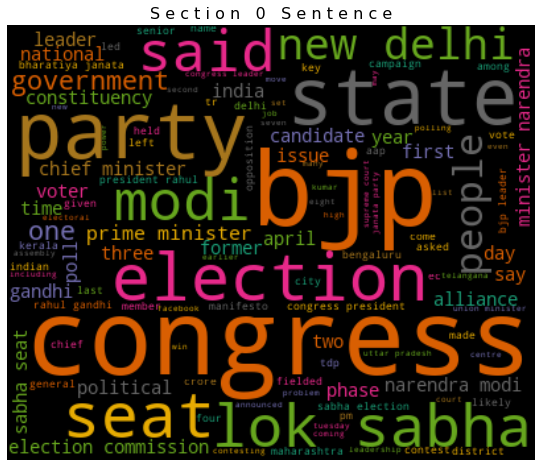

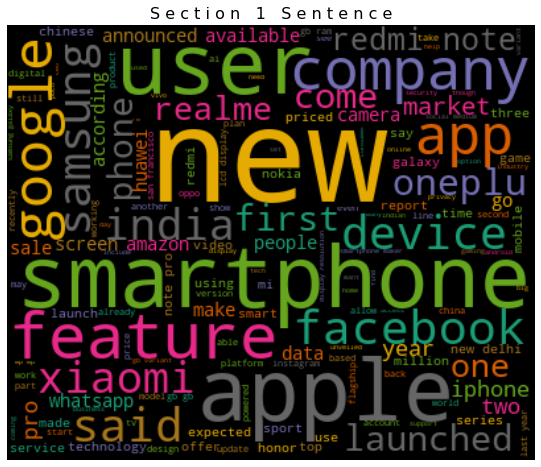

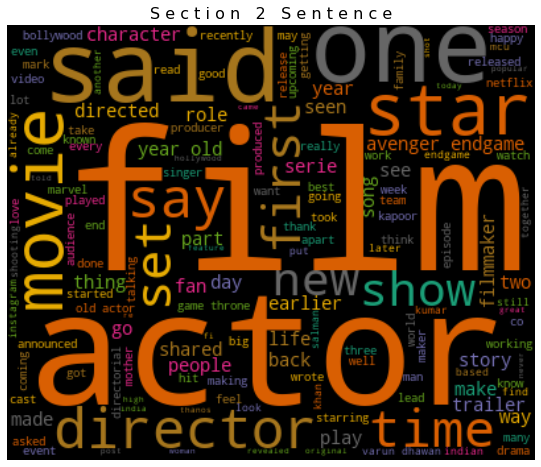

In [17]:
# Plotting word cloud for each product
for section in (newsTopicData_EDA['SECTION'].unique()):
    generate_wordcloud(newsTopicData_EDA[newsTopicData_EDA['SECTION'] == section]['STORY_TokenLemma'],section)

The understanding seems to be inline with our initial finding from charts

# Building the Model

In [18]:
newsTopicData_Model = newsTopicData.copy()
newsTopicData_Model.head()

,SECTION,STORY_TokenLemma,STORY_TokenLemma_Noun,STORY_TokenLemma_Adj,STORY_TokenLemma_Adv
0,3,painful huge reversal fee income unheard among...,gain investor fee bank loan book future sacrif...,come huge fee nasty unheard stable structured ...,essentially rather well
1,0,formidable opposition alliance among congress ...,vikas prajatantrikConfusion alliance jmmConfus...,congress formidable,
2,3,asian currency trading lower today south korea...,index china rupiah currency ringgit dollar str...,indonesian korean major previous south asian j...,offshore however close
3,1,want answer question click answer clicking ans...,question proceed answer homepage prefix voice ...,many neighbour icon follow user ask,already reply also
4,3,global market gold price edged today disappoin...,concern appetite activity ounce spot equity pr...,chinese european global asian,


In [19]:
train_x, valid_x, train_y, valid_y = train_test_split(newsTopicData_Model['STORY_TokenLemma'],
                                                    newsTopicData_Model['SECTION'], test_size=0.3, random_state=7)

# Count Vectorizer as Features

Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document.

In [20]:
# create a count vectorizer object 
count_vect = CountVectorizer()
count_vect.fit(newsTopicData_Model['STORY_TokenLemma'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

# TF IDF as Features

TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)

a. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents
b. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams
c. Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams in the corpus

In [21]:
# word level tf-idf
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(newsTopicData_Model['STORY_TokenLemma'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(ngram_range=(2,3))
tfidf_vect_ngram.fit(newsTopicData_Model['STORY_TokenLemma'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',ngram_range=(2,3))
tfidf_vect_ngram_chars.fit(newsTopicData_Model['STORY_TokenLemma'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

# Definfing a Common Function to train the model

In [22]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    # calculating accuracy score
    acc_Score = accuracy_score(predictions, valid_y)
    class_Report = classification_report(valid_y, predictions)
    
    return (acc_Score, class_Report)

# Model Building with Naive Bayes

In [23]:
# Naive Bayes on Count Vectors
acc_Score, class_Report = train_model(MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("\n NB, Count Vectors Accuracy: \n", acc_Score)
print ("\n NB, Count Vectors Classification Report: \n", class_Report)

# Naive Bayes on Word Level TF IDF Vectors
acc_Score, class_Report = train_model(MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("\n NB, WordLevel TF-IDF Accuracy: \n", acc_Score)
print ("\n NB, WordLevel TF-IDF Classification Report: \n", class_Report)

# Naive Bayes on Ngram Level TF IDF Vectors
acc_Score, class_Report = train_model(MultinomialNB(), 
                                                   xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("\n NB, N-Gram Vectors TF-IDF Accuracy: \n", acc_Score)
print ("\n NB, N-Gram Vectors TF-IDF Classification Report: \n", class_Report)

# Naive Bayes on Character Level TF IDF Vectors
acc_Score, class_Report = train_model(MultinomialNB(), 
                                                   xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("\n NB, CharLevel Vectors TF-IDF Accuracy: \n", acc_Score)
print ("\n NB, CharLevel Vectors TF-IDF Classification Report: \n", class_Report)


 NB, Count Vectors Accuracy: 
 0.9689820882481432

 NB, Count Vectors Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       488
           1       0.97      0.98      0.98       846
           2       0.99      0.94      0.96       557
           3       0.97      0.99      0.98       398

    accuracy                           0.97      2289
   macro avg       0.97      0.97      0.97      2289
weighted avg       0.97      0.97      0.97      2289


 NB, WordLevel TF-IDF Accuracy: 
 0.9244211446046309

 NB, WordLevel TF-IDF Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       488
           1       0.85      0.99      0.92       846
           2       0.99      0.87      0.93       557
           3       0.99      0.85      0.92       398

    accuracy                           0.92      2289
   macro avg       0.95      0.91      0.

We are seeing maximum accuracy with Naive Bayes with Count Vectorization

# Model Building with Linear Model for Classification

In [24]:
# Logistic Regression on Count Vectors
acc_Score, class_Report = train_model(LogisticRegression(solver='lbfgs',multi_class='auto'), 
                                                   xtrain_count, train_y, xvalid_count)
print ("\n LR, Count Vectors Accuracy: \n", acc_Score)
print ("\n LR, Count Vectors Classification Report: \n", class_Report)

# Logistic Regression on Word Level TF IDF Vectors
acc_Score, class_Report = train_model(LogisticRegression(solver='lbfgs',multi_class='auto'), 
                                                   xtrain_tfidf, train_y, xvalid_tfidf)
print ("\n LR, WordLevel TF-IDF Accuracy: \n", acc_Score)
print ("\n LR, WordLevel TF-IDF Classification Report: \n", class_Report)

# Logisitic Regression on Ngram Level TF IDF Vectors
acc_Score, class_Report = train_model(LogisticRegression(solver='lbfgs',multi_class='auto'), 
                                                   xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("\n LR, N-Gram Vectors TF-IDF Accuracy: \n", acc_Score)
print ("\n LR, N-Gram Vectors TF-IDF Classification Report: \n", class_Report)

# Logistic Regression on Character Level TF IDF Vectors
acc_Score, class_Report = train_model(LogisticRegression(solver='lbfgs',multi_class='auto'), 
                                                   xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("\n LR, CharLevel Vectors TF-IDF Accuracy: \n", acc_Score)
print ("\n LR, CharLevel Vectors TF-IDF Classification Report: \n", class_Report)


 LR, Count Vectors Accuracy: 
 0.9567496723460026

 LR, Count Vectors Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       488
           1       0.96      0.97      0.97       846
           2       0.91      0.98      0.94       557
           3       0.98      0.95      0.97       398

    accuracy                           0.96      2289
   macro avg       0.96      0.95      0.96      2289
weighted avg       0.96      0.96      0.96      2289


 LR, WordLevel TF-IDF Accuracy: 
 0.9619921363040629

 LR, WordLevel TF-IDF Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       488
           1       0.96      0.98      0.97       846
           2       0.93      0.98      0.96       557
           3       0.98      0.96      0.97       398

    accuracy                           0.96      2289
   macro avg       0.97      0.96      0.

# Model Building with Ensemble Approach for Classification

In [25]:
# Random Forest on Count Vectors
acc_Score, class_Report = train_model(RandomForestClassifier(n_estimators=100), 
                                                   xtrain_count, train_y, xvalid_count)
print ("\n RF, Count Vectors Accuracy: \n", acc_Score)
print ("\n RF, Count Vectors Classification Report: \n", class_Report)

# Random Forest on Word Level TF IDF Vectors
acc_Score, class_Report = train_model(RandomForestClassifier(n_estimators=100), 
                                                   xtrain_tfidf, train_y, xvalid_tfidf)
print ("\n RF, WordLevel TF-IDF Accuracy: \n", acc_Score)
print ("\n RF, WordLevel TF-IDF Classification Report: \n", class_Report)

# Random Forest on Ngram Level TF IDF Vectors
acc_Score, class_Report = train_model(RandomForestClassifier(n_estimators=100), 
                                                   xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("\n RF, N-Gram Vectors TF-IDF Accuracy: \n", acc_Score)
print ("\n RF, N-Gram Vectors TF-IDF Classification Report: \n", class_Report)

# Random Forest on Character Level TF IDF Vectors
acc_Score, class_Report = train_model(RandomForestClassifier(n_estimators=100), 
                                                   xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("\n RF, CharLevel Vectors TF-IDF Accuracy: \n", acc_Score)
print ("\n RF, CharLevel Vectors TF-IDF Classification Report: \n", class_Report)


 RF, Count Vectors Accuracy: 
 0.9484491044124072

 RF, Count Vectors Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       488
           1       0.95      0.97      0.96       846
           2       0.92      0.96      0.94       557
           3       0.99      0.92      0.95       398

    accuracy                           0.95      2289
   macro avg       0.95      0.94      0.95      2289
weighted avg       0.95      0.95      0.95      2289


 RF, WordLevel TF-IDF Accuracy: 
 0.9493228484054173

 RF, WordLevel TF-IDF Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       488
           1       0.95      0.97      0.96       846
           2       0.91      0.97      0.94       557
           3       0.99      0.92      0.95       398

    accuracy                           0.95      2289
   macro avg       0.95      0.94      0.

# Defining a Common Function for GridSearchCV
(The configuration of parameters is invalid in some cases so to avoid exception/value error, we have introduced error_score parameter as 0.0, default value is 'raise')

In [27]:
def train_model_GridSearchCV(classifier, feature_vector_train, label, feature_vector_valid, search_param):
    # define search
    search = GridSearchCV(classifier, search_param, scoring='accuracy', cv=3, error_score=0.0)
    
    # execute search
    search.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = search.best_estimator_.predict(feature_vector_valid)
    
    # calculating accuracy score
    acc_Score = search.best_score_
    best_Params = search.best_params_
    class_Report = classification_report(valid_y, predictions)
    
    return (acc_Score, best_Params, class_Report)

# GridSearchCV with Logistic Regression

In [36]:
import warnings
warnings.filterwarnings('ignore')

# Defining search parameters for Logistic Regression
search_param = dict()
search_param['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
search_param['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
search_param['C'] = [0.001, 0.01, 0.1, 1, 10, 100]

# Logistic Regression on Count Vectors
acc_Score, best_Params, class_Report = train_model_GridSearchCV(LogisticRegression(), xtrain_count, 
                                                                train_y, xvalid_count, search_param)
print ("\n LR, Count Vectors Accuracy: \n", acc_Score)
print ("\n LR, Count Vectors Best Hyperparameters: \n", best_Params)
print ("\n LR, Count Vectors Classification Report: \n", class_Report)

# Logistic Regression on Word Level TF IDF Vectors
acc_Score, best_Params, class_Report = train_model_GridSearchCV(LogisticRegression(), xtrain_tfidf, 
                                                                train_y, xvalid_tfidf, search_param)
print ("\n LR, WordLevel TF-IDF Accuracy: \n", acc_Score)
print ("\n LR, WordLevel TF-IDF Best Hyperparameters: \n", best_Params)
print ("\n LR, WordLevel TF-IDF Classification Report: \n", class_Report)

# Logisitic Regression on Ngram Level TF IDF Vectors
acc_Score, best_Params, class_Report = train_model_GridSearchCV(LogisticRegression(), xtrain_tfidf_ngram, 
                                                                train_y, xvalid_tfidf_ngram, search_param)
print ("\n LR, N-Gram Vectors TF-IDF Accuracy: \n", acc_Score)
print ("\n LR, N-Gram Vectors TF-IDF Best Hyperparameters: \n", best_Params)
print ("\n LR, N-Gram Vectors TF-IDF Classification Report: \n", class_Report)

# Logistic Regression on Character Level TF IDF Vectors
acc_Score, best_Params, class_Report = train_model_GridSearchCV(LogisticRegression(), xtrain_tfidf_ngram_chars, 
                                                                train_y, xvalid_tfidf_ngram_chars, search_param)
print ("\n LR, CharLevel Vectors TF-IDF Accuracy: \n", acc_Score)
print ("\n LR, CharLevel Vectors TF-IDF TF-IDF Best Hyperparameters: \n", best_Params)
print ("\n LR, CharLevel Vectors TF-IDF Classification Report: \n", class_Report)


 LR, Count Vectors Accuracy: 
 0.9580445776362615

 LR, Count Vectors Best Hyperparameters: 
 {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

 LR, Count Vectors Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       488
           1       0.97      0.97      0.97       846
           2       0.92      0.98      0.95       557
           3       0.98      0.95      0.97       398

    accuracy                           0.96      2289
   macro avg       0.96      0.96      0.96      2289
weighted avg       0.96      0.96      0.96      2289


 LR, WordLevel TF-IDF Accuracy: 
 0.972092152088406

 LR, WordLevel TF-IDF Best Hyperparameters: 
 {'C': 0.001, 'penalty': 'none', 'solver': 'newton-cg'}

 LR, WordLevel TF-IDF Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       488
           1       0.98      0.99      0.98       846
          

# GridSearchCV with Random Forest

In [28]:
import warnings
warnings.filterwarnings('ignore')

# Defining search parameters for Random Forest Classifier
search_param = dict()
search_param['n_estimators'] = [10, 100, 1000]
search_param['max_features'] = ['sqrt', 'log2']

# Random Forest Classifier on Count Vectors
acc_Score, best_Params, class_Report = train_model_GridSearchCV(RandomForestClassifier(), xtrain_count, 
                                                                train_y, xvalid_count, search_param)
print ("\n RF, Count Vectors Accuracy: \n", acc_Score)
print ("\n RF, Count Vectors Best Hyperparameters: \n", best_Params)
print ("\n RF, Count Vectors Classification Report: \n", class_Report)

# Random Forest Classifier on Word Level TF IDF Vectors
acc_Score, best_Params, class_Report = train_model_GridSearchCV(RandomForestClassifier(), xtrain_tfidf, 
                                                                train_y, xvalid_tfidf, search_param)
print ("\n RF, WordLevel TF-IDF Accuracy: \n", acc_Score)
print ("\n RF, WordLevel TF-IDF Best Hyperparameters: \n", best_Params)
print ("\n RF, WordLevel TF-IDF Classification Report: \n", class_Report)

# Random Forest Classifier on Ngram Level TF IDF Vectors
acc_Score, best_Params, class_Report = train_model_GridSearchCV(RandomForestClassifier(), xtrain_tfidf_ngram, 
                                                                train_y, xvalid_tfidf_ngram, search_param)
print ("\n RF, N-Gram Vectors TF-IDF Accuracy: \n", acc_Score)
print ("\n RF, N-Gram Vectors TF-IDF Best Hyperparameters: \n", best_Params)
print ("\n RF, N-Gram Vectors TF-IDF Classification Report: \n", class_Report)

# Random Forest Classifier on Character Level TF IDF Vectors
acc_Score, best_Params, class_Report = train_model_GridSearchCV(RandomForestClassifier(), xtrain_tfidf_ngram_chars, 
                                                                train_y, xvalid_tfidf_ngram_chars, search_param)
print ("\n RF, CharLevel Vectors TF-IDF Accuracy: \n", acc_Score)
print ("\n RF, CharLevel Vectors TF-IDF TF-IDF Best Hyperparameters: \n", best_Params)
print ("\n RF, CharLevel Vectors TF-IDF Classification Report: \n", class_Report)


 RF, Count Vectors Accuracy: 
 0.9456827121183742

 RF, Count Vectors Best Hyperparameters: 
 {'max_features': 'log2', 'n_estimators': 1000}

 RF, Count Vectors Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       488
           1       0.95      0.97      0.96       846
           2       0.90      0.98      0.94       557
           3       1.00      0.91      0.95       398

    accuracy                           0.95      2289
   macro avg       0.96      0.94      0.95      2289
weighted avg       0.95      0.95      0.95      2289


 RF, WordLevel TF-IDF Accuracy: 
 0.9475557220453268

 RF, WordLevel TF-IDF Best Hyperparameters: 
 {'max_features': 'log2', 'n_estimators': 1000}

 RF, WordLevel TF-IDF Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       488
           1       0.95      0.97      0.96       846
           2       

KeyboardInterrupt: 

# Predicting the News Topic (SECTION) for Test Data

In [29]:
newsTopicData_Test = pd.read_excel('/Users/pritigirishvankudre/DayX_Lockdown Practice/News Topic Classification/Data_Test.xlsx')

In [30]:
'''Scrubbing the data for some unwanted data and to convert emoji/emoticons to meaningful words'''

newsTopicData_Test['STORY'] = newsTopicData_Test['STORY'].apply(lambda x: scrub_data(x))

In [31]:
'''Tokeninzing sentence to word'''

newsTopicData_Test['STORY_Token'] = newsTopicData_Test['STORY'].apply(lambda x: nltk.word_tokenize(x))

In [32]:
'''Lemmatization: Converting to stem word and joining back into sentence'''

newsTopicData_Test['STORY_TokenLemma'] = newsTopicData_Test['STORY_Token'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) 
                                                                                           for word in x]))

# Definfing a common function to test the model

In [33]:
def test_model(feature_vector_valid, transform_feature, classifier, feature_vector_train, label):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # transform using vector feature
    feature_vector_valid_transform = transform_feature.transform(feature_vector_valid)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid_transform)
    
    return (predictions)

# Building Test model with Naive Bayes and different vectorization features

In [33]:
prediction_count_vect_NB = test_model(newsTopicData_Test['STORY_TokenLemma'], count_vect, 
                                      MultinomialNB(), xtrain_count, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_count_vect_NB)
newsTopicData_Test['SECTION'].to_excel('NB_CV_Test_0705_00_1800.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

prediction_tfidf_vect_NB = test_model(newsTopicData_Test['STORY_TokenLemma'], tfidf_vect, 
                                      MultinomialNB(), xtrain_tfidf, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_tfidf_vect_NB)
newsTopicData_Test['SECTION'].to_excel('NB_CV_Test_0705_01_1801.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

prediction_tfidf_vect_ngram_NB = test_model(newsTopicData_Test['STORY_TokenLemma'], tfidf_vect_ngram, 
                                            MultinomialNB(), xtrain_tfidf_ngram, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_tfidf_vect_ngram_NB)
newsTopicData_Test['SECTION'].to_excel('NB_CV_Test_0705_02_1802.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

prediction_tfidf_vect_ngram_chars_NB = test_model(newsTopicData_Test['STORY_TokenLemma'], tfidf_vect_ngram_chars, 
                                                  MultinomialNB(), xtrain_tfidf_ngram_chars, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_tfidf_vect_ngram_chars_NB)
newsTopicData_Test['SECTION'].to_excel('NB_CV_Test_0705_03_1803.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

# Building Test model with Logistic Regression and different vectorization features

In [34]:
prediction_count_vect_LR = test_model(newsTopicData_Test['STORY_TokenLemma'], count_vect, 
                                      LogisticRegression(solver='lbfgs',multi_class='auto'), xtrain_count, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_count_vect_LR)
newsTopicData_Test['SECTION'].to_excel('LR_CV_Test_0705_00_1800.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

prediction_tfidf_vect_LR = test_model(newsTopicData_Test['STORY_TokenLemma'], tfidf_vect, 
                                      LogisticRegression(solver='lbfgs',multi_class='auto'), xtrain_tfidf, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_tfidf_vect_LR)
newsTopicData_Test['SECTION'].to_excel('LR_CV_Test_0705_01_1801.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

prediction_tfidf_vect_ngram_LR = test_model(newsTopicData_Test['STORY_TokenLemma'], tfidf_vect_ngram, 
                                            LogisticRegression(solver='lbfgs',multi_class='auto'), xtrain_tfidf_ngram, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_tfidf_vect_ngram_LR)
newsTopicData_Test['SECTION'].to_excel('LR_CV_Test_0705_02_1802.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

prediction_tfidf_vect_ngram_chars_LR = test_model(newsTopicData_Test['STORY_TokenLemma'], tfidf_vect_ngram_chars, 
                                                  LogisticRegression(solver='lbfgs',multi_class='auto'), xtrain_tfidf_ngram_chars, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_tfidf_vect_ngram_chars_LR)
newsTopicData_Test['SECTION'].to_excel('LR_CV_Test_0705_03_1803.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

# Building Test model with Random Forest and different vectorization features

In [35]:
prediction_count_vect_RF = test_model(newsTopicData_Test['STORY_TokenLemma'], count_vect, 
                                      RandomForestClassifier(n_estimators=100), xtrain_count, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_count_vect_RF)
newsTopicData_Test['SECTION'].to_excel('RF_CV_Test_0705_00_1800.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

prediction_tfidf_vect_RF = test_model(newsTopicData_Test['STORY_TokenLemma'], tfidf_vect, 
                                      RandomForestClassifier(n_estimators=100), xtrain_tfidf, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_tfidf_vect_RF)
newsTopicData_Test['SECTION'].to_excel('RF_CV_Test_0705_01_1801.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

prediction_tfidf_vect_ngram_RF = test_model(newsTopicData_Test['STORY_TokenLemma'], tfidf_vect_ngram, 
                                            RandomForestClassifier(n_estimators=100), xtrain_tfidf_ngram, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_tfidf_vect_ngram_RF)
newsTopicData_Test['SECTION'].to_excel('RF_CV_Test_0705_02_1802.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

prediction_tfidf_vect_ngram_chars_RF = test_model(newsTopicData_Test['STORY_TokenLemma'], tfidf_vect_ngram_chars, 
                                                  RandomForestClassifier(n_estimators=100), xtrain_tfidf_ngram_chars, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_tfidf_vect_ngram_chars_RF)
newsTopicData_Test['SECTION'].to_excel('RF_CV_Test_0705_03_1803.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

# Building Test Model with Logistic Regression and best parameters derived basis GridSearchCV

In [35]:
prediction_count_vect_LR = test_model(newsTopicData_Test['STORY_TokenLemma'], count_vect, 
                                      LogisticRegression(C=1, penalty='l2', solver='liblinear' 
                                                         ,multi_class='auto'), xtrain_count, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_count_vect_LR)
newsTopicData_Test['SECTION'].to_excel('LR_CV_Test_1205_00_2200.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)

prediction_tfidf_vect_LR = test_model(newsTopicData_Test['STORY_TokenLemma'], tfidf_vect, 
                                      LogisticRegression(C=0.001, penalty='none', solver='newton-cg' 
                                                         ,multi_class='auto'), xtrain_tfidf, train_y)
newsTopicData_Test['SECTION'] = pd.DataFrame(prediction_tfidf_vect_LR)
newsTopicData_Test['SECTION'].to_excel('LR_CV_Test_1205_01_2201.xlsx' ,header=True, index=False)
newsTopicData_Test.drop(['SECTION'], axis=1, inplace=True)